In [3]:
# Install the necessary dependencies

import os
import sys
!{sys.executable} -m pip install --quiet pandas scikit-learn numpy matplotlib jupyterlab_myst ipython tensorflow_addons opencv-python requests

---
license:
    code: MIT
    content: CC-BY-4.0
github: https://github.com/ocademy-ai/machine-learning
venue: By Ocademy
open_access: true
bibliography:
  - https://raw.githubusercontent.com/ocademy-ai/machine-learning/main/open-machine-learning-jupyter-book/references.bib
---

# Diffusion Model

Diffusion model in deep learning is a type of generative model. The core idea of this model is to generate data by gradually adding noise. Specifically, diffusion models achieve data generation through two processes: diffusion process and inverse diffusion process.

Forward Diffusion Process: In this process, the model gradually adds noise to the data, making it increasingly random and unpredictable.
Reverse Diffusion Process: This process attempts to gradually remove the added noise, gradually restoring the data to its original state.

By alternately applying these two processes, diffusion models can generate high-quality data samples.

<img src="https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/diffusion-model/04_frdiffusion.png" width="90%" class="bg-white mb-1">

## Background

Before we learn the diffusion model, we have to know some background knowledge in statistics. Perhaps you already have a good mastery of them, let's review them together.

### Expectation

#### Definition

In probability theory, expectation (also called expected value, mean, average) is a generalization of the weighted average.

$E[X] = x_1 p_1 + x_2 p2 + ... +x_n p_n = \sum_{i=1}^n x_i p_1$

where $x_i$ and $p_i$ are i-th a possible outcome and its probability, respectively.

#### Properties

- $E[aX]=aE[X]$ where a is a constant value.
- $E[X+b]=E[X]+b$ where b is a constant value.
- $E[X+Y]=E[X]+E[Y]$.

### Variance

Variance is a measure of dispersion, meaning it is a measure of how far a set of numbers is spread out from their average value.

#### Definition

The variance of a random variable $X$ is the expected value of the squared deviation from the expectation of $X$.

#### Properties

- $Var[X]=E[X^2]−E[X]^2$.
- $Var[aX]=a^2 Var[X]$ where a is a constant value.
- $Var[X+b]=Var[X]$ where b is a constant value.
- $Var[X+Y]=Var[X]+Var[Y]$.

### Re-parameterization trick

When we sample data from a probability distribution, backpropagation the gradient is not possible because it is a stochastic process. To make it trainable, the re-parameterization trick is useful.

Let us assume that $z$ is sampled data from a gaussian distribution which the mean is $\mu$ and the variance is $\sigma^2$. Then, the mean and variance of $z$ would be $\mu$ and $\sigma^2$. Therefore, $z$ can be written as follows.

$z = N(\mu, \sigma^2 I) = \mu + \sigma \odot \epsilon$, where $\epsilon \thicksim N(0, I)$

where $\odot$ refers to element-wise product.

The mean and variance of $z$ correspond to $\mu$ and $\sigma^2$, respectively.

#### Mean (Expectation)

$E[z] = E[\mu+\sigma \odot \epsilon] = E[\mu] + \sigma E[\epsilon] = \mu$

The expectation of $\epsilon$ is 0 by definition.

#### Variance

$Var[z] = Var[\mu + \sigma \odot \epsilon] = Var[\sigma \odot \epsilon] = \sigma^2 Var[\epsilon] = \sigma^2$

The variance of \epsilon is 1 by definition.

### KL Divergence

In mathematical statistics, the Kullback–Leibler divergence (relative entropy), is a type of statistical distance.

#### Definition

1. Discrete probability distribution

$D_{KL}(P||Q) = \sum_{x \in X} P(x) log \frac{P(x)}{Q(x)}$,where $P$ and $Q$ are discrete probability distributions.

2. Continuous probability distribution

$D_{KL} (P||Q) = \int _{− \infty}^{\infty} p(x) log \frac{p(x)}{q(x)}dx$, where $p$ and $q$ denote the probability densities of $P$ and $Q$.

#### Jensen's inequality

In mathematics, Jensen's inequality relates the value of a convex (or concave) function of an integral to the integral of the function.

- Convex function: $f(E[X]) \leqq E[f(X)]$;
- Concave function: $f(E[X]) \geqq E[f(X)]$.

#### Properties of KL Divergence

- KL Divergence is always non-negative;
- The cross-entropy is always larger than the entropy;
- Two univariate normal distributions $P$ and $Q$ are simplified to $D_{KL}(P||Q) = log \frac{\sigma_q}{\sigma_p} + \frac{\sigma^2_p + (\mu_p − \mu_q)^2}{2\sigma^2_q} − \frac{1}{2}$.

### Evidence lower bound (ELBO)

In variational Bayesian methods, the evidence lower bound (often abbreviated ELBO) is a useful lower bound on the log-likelihood of some observed data.

#### Definition

$ELBO := E_{z∼q_{\phi}}[log \frac{pθ(x,z)}{q_{\phi}(z)}]$

where $p_{\theta}(x, z)$ is joint distribution of $x$ and $z$. $\theta$ and $\phi$ are parameters.

ELBO is used to obtain the lower bound of the evidence (or log evidence). The evidence is the likelihood function evaluated at a fixed $\theta$.

$evidence := log p_{\theta}(x)$

#### Properties

- The evidence is always larger than ELBO;
- KL Divergence between $p_{\theta}(z|x)$ and $q_{\phi}(z)$ equals $evidence−ELBO$.

# Forward and Reverse Process

Diffusion models transform data into Gaussian noise (latent vector) and then restore it. The former is called the forward process, and the latter is called the reverse process.

## Forward Diffusion Process

In the forward process, we add a gaussian noise to the data step by step (usually hundreds of steps).

The transform of an individual step is defined as follows.
$x_t = q(x_t|x_{t−1}) = N(x_t, \sqrt{1−\beta_t}x_{t−1}, \beta_t I)$

<img src="https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/diffusion-model/05_forward.jpg" width="90%" class="bg-white mb-1">

The forward diffusion process progressively adds Gaussian noise to the input image $x_0$ over $T$ steps, producing a series of noisy image samples $x_1, \ldots, x_T$.

As $T \rightarrow \infty$, the final result will converge to an image fully corrupted by noise, akin to sampling from an isotropic Gaussian distribution.

The inefficiency of Pythonic loops, particularly with large timestamps, can cause significant slowdowns. To address this, we employ a reparameterization trick, which uses an approximation method to generate noise at specific timestamps, avoiding the need for explicit iteration.

$\alpha_t := 1 - \beta_t$,
$\bar{\alpha}_t := \prod_{s=1}^{t} \alpha_s$,
$q(x_t | x_0) = \mathcal{N}\left( x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) I \right)$

We've isolated the variance schedule and calculated the cumulative product of this variable $α_t$. This equation allows us to directly sample the noisy image at any time step using just the original image $( x_0 )$.

## Reverse Diffusion Process

In the reverse process, we restore image from a gaussian noise (a latent vector). If $\beta_t$ is small enough, the reverse $q(x_{t-1}|x_t)$ will also be gaussian. It is noteworthy that the reverse process is tractable when conditioned on $x_0$.

<img src="https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/diffusion-model/01_structure.png" width="90%" class="bg-white mb-1">

The forward process is different; we cannot use $q(x_{t-1}|x_t)$ to reverse the noise because it is difficult (or impossible) to compute. Therefore, we need to train a neural network $p_θ(xₜ₋₁|xₜ)$ to approximate $q(x_{t-1}|x_t)$.

$p_{\theta}(x_{t-1}|x_{t}) := \mathcal{N}(x_{t-1}; \mu(x_{t}, t), \Sigma_{\theta}(x_{t}, t))$

$p_{\theta}(x_{0:T}) = p_{\theta}(x_{T}) \prod_{t=1}^{T} p_{\theta}(x_{t-1}|x_{t})$

$p_{\theta}(x_{0}) := \int p_{\theta}(x_{0:T}) dx_{1:T}$

### Loss Function

In a diffusion model, the goal of the reverse diffusion process is to infer the noise-free original image that generated the observed noisy image. To achieve this, we train a neural network to approximate the inverse of the noise process. The training of this neural network is accomplished by minimizing a loss function.

First,We define loss function using negative log likelihood & ELBO:

$$
\begin{aligned}
\log p_{\theta}(x_0) &= \log p_{\theta}(x_0 | x_{1:T}) + \log p_{\theta}(x_{1:T}) - \log p_{\theta}(x_{1:T} | x_0) \\
\mathbb{E}_{q}[ \log p_{\theta}(x_0) ] &= \int q(x_{1:T} | x_0) \log p_{\theta}(x_0) dx_{1:T} \\
&= \int q(x_{1:T} | x_0) [ \log p_{\theta}(x_0 | x_{1:T}) + \log p_{\theta}(x_{1:T}) - \log p_{\theta}(x_{1:T} | x_0) ] dx_{1:T} \\
&= \mathbb{E}_{q}[ \log p_{\theta}(x_0 | x_{1:T}) ] + \int q(x_{1:T} | x_0) \log p_{\theta}(x_{1:T}) dx_{1:T} \\
&- \int q(x_{1:T} | x_0) \log p_{\theta}(x_{1:T} | x_0) dx_{1:T}
\end{aligned}
$$

Then,chenge to tractable form:

<img src="https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/diffusion-model/06_lossformula.png" width="90%" class="bg-white mb-1">

Finally,simplify training objective:

We will use $D_{KL}(q(x_{t-1} | x_t, x_0) || p_{\theta}(x_{t-1} | x_t) )$ for simplifying the loss function. In the paper, the author trained the model using this part as a training objective.

So, our challenge has been narrowed down to training the two distributions $ q(x_{t-1} | x_t, x_0) $ and $ p_{\theta}(x_{t-1} | x_t) $ as equally as possible.

$$ q(x_{t-1} | x_t, x_0) = N(x_{t-1}; \hat{\mu}(x_t, x_0), \hat{\beta}I),
 p_{\theta}(x_{t-1} | x_t) = N(x_{t-1}; \mu_{\theta}(x_t, t), \sigma_t^2 I) $$
$$
\begin{aligned}
D_{KL}(q(x_{t-1} | x_t, x_0) || p_{\theta}(x_{t-1} | x_t)) &= E_{x_0, \epsilon} \left[ \frac{{\beta_t^2}}{{2\sigma_t^2} \alpha_t (1 - \hat{\alpha}_t)} || \epsilon - \epsilon_{\theta}(\sqrt{\hat{\alpha}_t}x_0 + \sqrt{1 - \hat{\alpha}_t} \epsilon, t) ||^2 \right] \\\frac{{\beta_t^2}}{{2\sigma_t^2} \alpha_t (1 - \hat{\alpha}_t)} &\text{ is considered as a constant in the paper}
\end{aligned}
$$

Final Loss:
$$
\begin{aligned}
E_{x_0, \epsilon}[ || \epsilon - \epsilon_{\theta}(\sqrt{\hat{\alpha}_t}x_0 + \sqrt{1 - \hat{\alpha}_t} \epsilon, t) ||^2 ]
\end{aligned}
$$


### Noise schedule

In diffusion models, the noise schedule define the methodology for iteratively adding noise to an image or for updating a sample based on model outputs. I'll introduce two type of schedules which are linear schedule and cosine schedule. The linear and cosine schedule were introduced by [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239) and [Improved Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239), respectively.

#### Linear schedule

In the linear schedule, $\beta_t$ changes linearly.


<img src="https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/diffusion-model/02_linear.png" width="90%" class="bg-white mb-1">

Illustration of linear schedule


#### Cosine schedule

Alex Nichol and Prafulla Dhariwal proposed the cosine schedule to prevent an image from turning into noise too quickly. They construct a different noise schedule in terms of $\overline{\alpha_t}$.

$\overline{\alpha_t} = \frac{f(t)}{f(0)}$, $f(t) = cos(\frac{\frac{t}{T} + s}{1+s} \frac{\pi}{2})^2$. By definition, the $\beta_t$ equals $1 - \frac{\overline{\alpha_t}}{\overline{\alpha_{t-1}}}$.


<img src="https://static-1300131294.cos.ap-shanghai.myqcloud.com/images/deep-learning/diffusion-model/03_cosine.png" width="90%" class="bg-white mb-1">

Illustration of cosine schedule

## Code

### Import Libraries

In [4]:
import tensorflow as tf
import numpy as np
import cv2
import time
import requests
import zipfile
import io
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Reshape, Conv2DTranspose, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, Input, BatchNormalization, Input, MultiHeadAttention)
from tensorflow.keras.optimizers import Adam
import tensorflow_addons as tfa

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
BATCH_SIZE = 32
TIME_STEPS = 1000
IM_SHAPE = (32,32,3)
N_HEADS = 8
ATTN_DIM = 256
N_GROUPS = 8
N_RESNETS = 2
LEARNING_RATE = 2e-4
EPOCHS = 10
FACTOR = 2

### Data Loading
The dataset can be downloaded from [here](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset).

In [6]:
url = 'https://static-1300131294.cos.ap-shanghai.myqcloud.com/data/deep-learning/diffusion-model/archive.zip'

r = requests.get(url)
with zipfile.ZipFile(io.BytesIO(r.content), 'r') as zip_ref:
    zip_ref.extractall('./')


In [7]:
ds_train = tf.keras.preprocessing.image_dataset_from_directory(
    "t/celebA", label_mode=None, image_size=(IM_SHAPE[0], IM_SHAPE[1]), batch_size=BATCH_SIZE)

Found 30000 files belonging to 1 classes.


### Data Preprocessing

In [8]:
def preprocess(image):
    return tf.cast(image, tf.float32) / 127.5 - 1.0

### Data Augmentation

In [9]:
def augmentation(image):
    return tf.image.random_flip_left_right(image)

### Data

In [10]:
train_dataset = (
    ds_train
    .map(preprocess)
    .map(augmentation)
    .unbatch()
    .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
    .batch(BATCH_SIZE,drop_remainder=True)
    .prefetch(tf.data.AUTOTUNE))

### Linear schedule-beta

In [11]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return tf.linspace(beta_start, beta_end, timesteps)

In [12]:
betas = linear_beta_schedule(TIME_STEPS)
print(betas)

tf.Tensor(
[9.99999975e-05 1.19919918e-04 1.39839831e-04 1.59759758e-04
 1.79679686e-04 1.99599599e-04 2.19519512e-04 2.39439454e-04
 2.59359367e-04 2.79279280e-04 2.99199193e-04 3.19119135e-04
 3.39039048e-04 3.58958961e-04 3.78878904e-04 3.98798817e-04
 4.18718730e-04 4.38638643e-04 4.58558556e-04 4.78478498e-04
 4.98398382e-04 5.18318324e-04 5.38238266e-04 5.58158150e-04
 5.78078092e-04 5.97998034e-04 6.17917918e-04 6.37837860e-04
 6.57757802e-04 6.77677686e-04 6.97597628e-04 7.17517512e-04
 7.37437455e-04 7.57357397e-04 7.77277281e-04 7.97197223e-04
 8.17117107e-04 8.37037049e-04 8.56956991e-04 8.76876875e-04
 8.96796817e-04 9.16716759e-04 9.36636643e-04 9.56556585e-04
 9.76476527e-04 9.96396411e-04 1.01631635e-03 1.03623618e-03
 1.05615612e-03 1.07607606e-03 1.09599601e-03 1.11591583e-03
 1.13583577e-03 1.15575572e-03 1.17567566e-03 1.19559560e-03
 1.21551554e-03 1.23543537e-03 1.25535531e-03 1.27527525e-03
 1.29519519e-03 1.31511514e-03 1.33503496e-03 1.35495490e-03
 1.37487485e-

In [13]:
alphas = 1. - betas
alphas_cumprod = tf.math.cumprod(alphas, axis=0)
sqrt_alphas_cumprod = tf.math.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = tf.math.sqrt(1. - alphas_cumprod)

In [14]:
def extract(a, t, x_shape):
    b, *_ = t.shape
    out = tf.gather(a,t)
    output = tf.reshape(out, (b,*((1,) * (len(x_shape) - 1))))
    return output

def q_sample(x_start, t, noise):

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    out_sample = sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise### x_start=x_0, noise = z
    return out_sample

In [15]:
class PositionalEmbeddings(tf.keras.layers.Layer):

    def __init__(self, dim):
        super().__init__()
        self.embedding_dim = dim

    def get_timestep_embedding(self, timesteps, embedding_dim: int):
        """
        From Fairseq.
        Build sinusoidal embeddings.
        This matches the implementation in tensor2tensor, but differs slightly
        from the description in Section 3.5 of "Attention Is All You Need".
        """
        half_dim = self.embedding_dim // 2
        emb = tf.math.log(10000.) / (half_dim - 1)
        emb = tf.exp(tf.range(half_dim, dtype=tf.float32) * -emb)
        emb = tf.cast(timesteps, dtype = tf.float32)[:, None] * emb[None, :]
        emb = tf.concat([tf.sin(emb), tf.cos(emb)], axis=1)
        if embedding_dim % 2 == 1:
            emb = tf.pad(emb, [[0, 0], [0, 1]])
        return emb

    def call(self, time):
        return self.get_timestep_embedding(time, self.embedding_dim)
def res_block(x,filters,n_groups,temb):
    previous = x
    x = Conv2D(filters, 3, padding="same",)(x) ### Convolution layer with padding same, so that the resolution remains the same

    ### temb represents the time embedding.
    ### It is passed into the silu activation function and a Dense Layer(Which can change the the embedding dimension )
    ### We also reshape the time embedding to match the output of 2d convnets.
    x += Dense(filters)(tf.nn.silu(temb))[:,None,None,:]

    ### Group Normalization is used.
    x = tf.nn.silu(tfa.layers.GroupNormalization(n_groups, axis = -1)(x))
    x = Conv2D(filters, 3, padding="same",)(x)

    # Project residual
    residual = Conv2D(filters, 1,padding="same",)(previous)
    x = tf.keras.layers.add([x, residual])  # Add back residual
    return x

def get_model(im_shape=(64,64,3),n_resnets=2,n_groups=8,attn_dim=32,n_heads=4,):
    input_1 = Input(shape=im_shape)### image input
    input_2 = Input(shape=())### time input
    t_dim = im_shape[0]*16

    # Entry block
    x = Conv2D(32, 3, padding="same")(input_1)
    temb = PositionalEmbeddings(t_dim)(input_2)### Create embeddings from the time input_2
    temb = Dense(t_dim)(tf.nn.gelu(Dense(t_dim)(temb)))### pass the embedding into the gelu activation function

    hs = [x]### variable used for storing each resolution level output, in the downward path, to be concatenated to the inputs of the upward path.

    ### Downward Path
    for filters in [32, 64, 128, 256]:### for every resolution level (32,64,128,256), represent the depth they map to resolutions of (32,16,8,4)
        for _ in range(n_resnets):### we go through each resnet block per resolution level
            x = res_block(x,filters,n_groups,temb)### resblock
            ### if the resolution=16 (coinciding with a depth=64), we make the resnet output features attend to each other.
            ### Note how the attention axes = (1,2). This corresponds to the height and width dimensions.
            ### Feel free to Check the documentation out :) https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention.
            ### query = key = value = x.
            ### We again use Group Normalization.
            if filters == 64:
                x = tfa.layers.GroupNormalization(groups=n_groups, axis = -1)(
                    MultiHeadAttention(num_heads=n_heads, key_dim=attn_dim, attention_axes=(1,2), )(query = x, value = x))
        hs.append(x)### append the output features to hs
        x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)### Downsampling in order to move to the next resolution level


    ### Bottleneck
    x = res_block(x,256,n_groups,temb)
    x = tfa.layers.GroupNormalization(groups=n_groups, axis = -1)(
      MultiHeadAttention(num_heads=n_heads, key_dim=attn_dim, attention_axes=(1,2), )(query = x, value = x))
    x = res_block(x,256,n_groups,temb)


    ### Upward path
    for filters in [256, 128, 64,32]:
        ### we resize x, to match with the shape of feature outputs (hs) in the downward path
        x = tf.image.resize_with_pad(x,hs[-1].shape[1],hs[-1].shape[2])
        x = tf.concat([x,hs.pop()], axis=-1)

        for _ in range(n_resnets):
            x = res_block(x,filters,n_groups,temb)

            if filters == 64:
                x = tfa.layers.GroupNormalization(groups=n_groups, axis = -1)(
                  MultiHeadAttention(num_heads=n_heads, key_dim=attn_dim, attention_axes=(1,2), )(query = x, value = x))

        if filters != 32:
            x = Conv2DTranspose(filters, 3, strides = (2,2),)(x)### Upsampling

    x = res_block(x,32,n_groups,temb)
    outputs = Conv2D(3, 3, padding="same", )(x)

    # Define the model
    model = Model([input_1,input_2], outputs,name='unet')
    return model

model= get_model(im_shape=IM_SHAPE,n_resnets=N_RESNETS,n_groups=N_GROUPS,attn_dim=ATTN_DIM,n_heads=N_HEADS,)
model.summary()

Model: "unet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 positional_embeddings (Pos  (None, 512)                  0         ['input_2[0][0]']             
 itionalEmbeddings)                                                                               
                                                                                                  
 dense_1 (Dense)             (None, 512)                  262656    ['positional_embeddings[0][0]'
                                                                    ]                             
                                                                                               

In [16]:
class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, init_lr):
        self.init_lr = init_lr

    def __call__(self, step):
        return self.init_lr*(100000/(step+100000))

OPTIMIZER = Adam(learning_rate=LRSchedule(1e-4))

def custom_loss(denoise_model, x_start, t, noise=None):
    ### Our custom loss function takes in the predicted noise and compares (using the Huber Loss) it with the actual noise
    ### Huber Loss with a default value for delta as 1.0 Check out the documentation: https://www.tensorflow.org/api_docs/python/tf/keras/losses/Huber
    h = tf.keras.losses.Huber()
    noise = tf.random.normal(x_start.shape,mean=0,stddev=1)### noise=epsilon=z
    x_noisy = q_sample(x_start,t,noise)### x_t using the q_sample method
    predicted_noise = denoise_model([x_noisy, t])### model takes in the x_t and t and outputs noise
    return h(noise,predicted_noise)

### custom training block
### You can use tf.function to make graphs out of your programs. It is a transformation tool that creates Python-independent dataflow graphs
### out of your Python code. This will help you create performant and portable models.
@tf.function
def training_block(x_batch):
    with tf.GradientTape() as recorder:
        ### for every element in the batch, we generate t randomly
        t = tf.random.uniform((BATCH_SIZE,),minval=0,maxval=TIME_STEPS,dtype=tf.int32)
        loss = custom_loss(model,x_batch,t)

    partial_derivatives = recorder.gradient(loss, model.trainable_weights)
    OPTIMIZER.apply_gradients(zip(partial_derivatives, model.trainable_weights))### gradient descent
    return loss

def neuralearn(EPOCHS):
    for epoch in range(EPOCHS):
        init_time = time.time()
        losses = []
        for step, x_batch in enumerate(train_dataset):
            loss = training_block(x_batch)
            losses.append(loss)

        print(str(epoch+1)+"/"+str(EPOCHS)+": Training Loss----->", sum(losses)/len(losses))
        print('Time Elapsed: ---> '+str(time.time()-init_time)+' s')

    print("Training Complete!!!!")

neuralearn(EPOCHS)

1/10: Training Loss-----> tf.Tensor(0.0851486, shape=(), dtype=float32)
Time Elapsed: ---> 271.93567872047424 s
2/10: Training Loss-----> tf.Tensor(0.03785207, shape=(), dtype=float32)
Time Elapsed: ---> 225.90968680381775 s
3/10: Training Loss-----> tf.Tensor(0.031987343, shape=(), dtype=float32)
Time Elapsed: ---> 227.73545622825623 s
4/10: Training Loss-----> tf.Tensor(0.028098105, shape=(), dtype=float32)
Time Elapsed: ---> 225.87372756004333 s
5/10: Training Loss-----> tf.Tensor(0.026988357, shape=(), dtype=float32)
Time Elapsed: ---> 226.86771440505981 s
6/10: Training Loss-----> tf.Tensor(0.026325967, shape=(), dtype=float32)
Time Elapsed: ---> 226.94463539123535 s
7/10: Training Loss-----> tf.Tensor(0.025573287, shape=(), dtype=float32)
Time Elapsed: ---> 226.3922827243805 s
8/10: Training Loss-----> tf.Tensor(0.025572365, shape=(), dtype=float32)
Time Elapsed: ---> 227.60708856582642 s
9/10: Training Loss-----> tf.Tensor(0.02489814, shape=(), dtype=float32)
Time Elapsed: ---> 

999
998
997
996
995
994
993
992
991
990
989
988
987
986
985
984
983
982
981
980
979
978
977
976
975
974
973
972
971
970
969
968
967
966
965
964
963
962
961
960
959
958
957
956
955
954
953
952
951
950
949
948
947
946
945
944
943
942
941
940
939
938
937
936
935
934
933
932
931
930
929
928
927
926
925
924
923
922
921
920
919
918
917
916
915
914
913
912
911
910
909
908
907
906
905
904
903
902
901
900
899
898
897
896
895
894
893
892
891
890
889
888
887
886
885
884
883
882
881
880
879
878
877
876
875
874
873
872
871
870
869
868
867
866
865
864
863
862
861
860
859
858
857
856
855
854
853
852
851
850
849
848
847
846
845
844
843
842
841
840
839
838
837
836
835
834
833
832
831
830
829
828
827
826
825
824
823
822
821
820
819
818
817
816
815
814
813
812
811
810
809
808
807
806
805
804
803
802
801
800
799
798
797
796
795
794
793
792
791
790
789
788
787
786
785
784
783
782
781
780
779
778
777
776
775
774
773
772
771
770
769
768
767
766
765
764
763
762
761
760
759
758
757
756
755
754
753
752
751
750


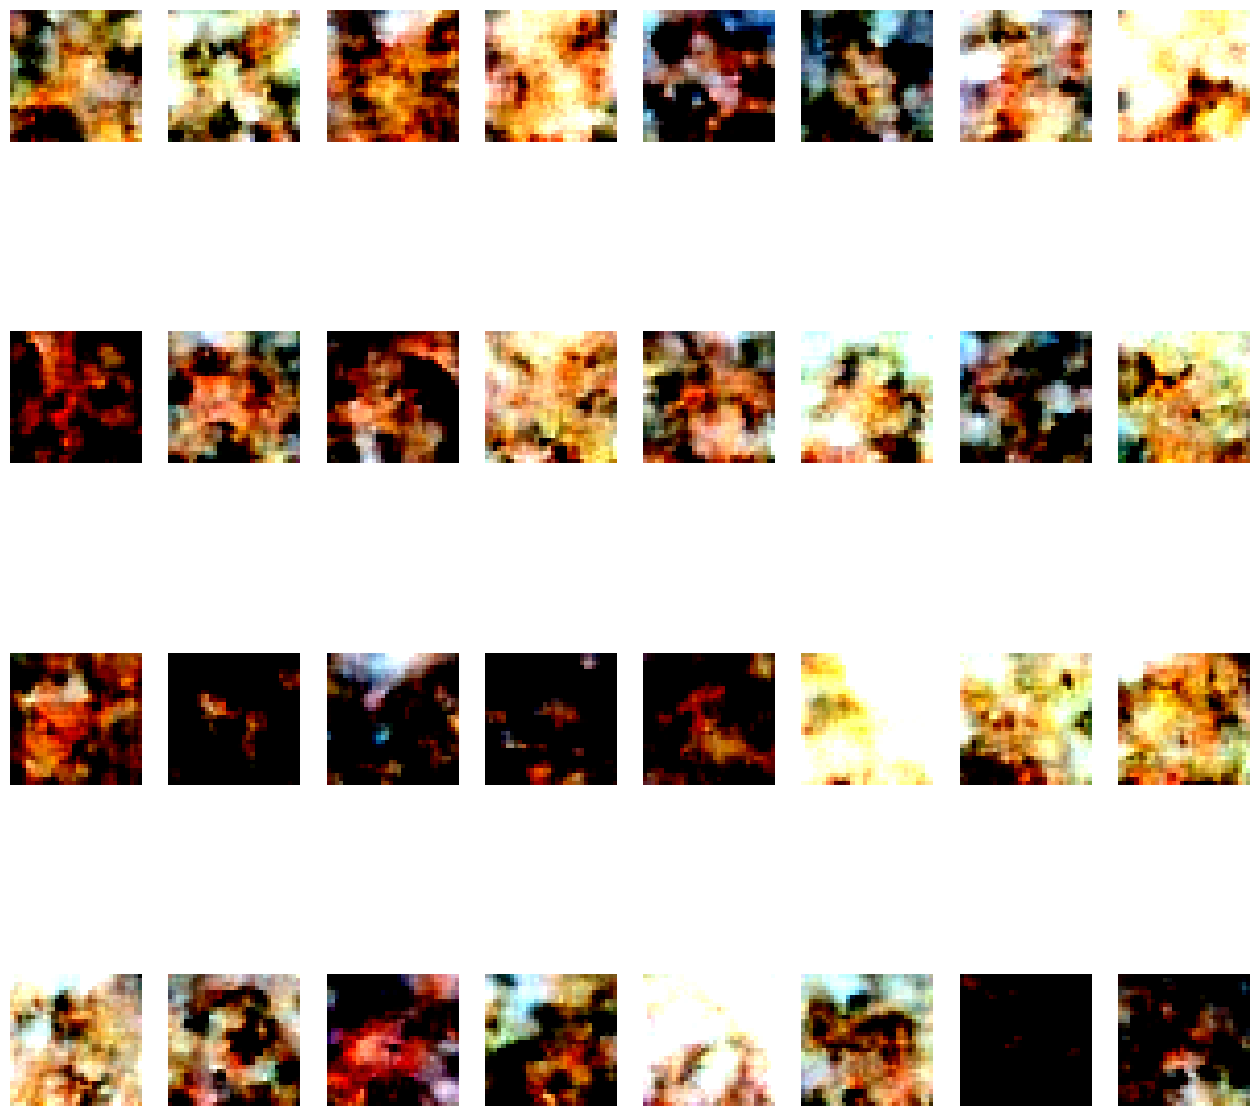

In [17]:
sqrt_recip_alphas = tf.math.sqrt(1.0 / alphas)
alphas_cumprod_prev = tf.concat([tf.ones((1,)),alphas_cumprod[:-1]],axis = 0)### alpha_t-1_bar = alphas_cumprod_prev

posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def p_sample(model, x, t, t_index):

    betas_t = extract(betas, t, x.shape)### betas_t = 1-alphas_t
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)### square root of 1-alpha_t_bar
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)### 1/square root of alpha_t

    model_mean = sqrt_recip_alphas_t * (x - betas_t * model([x, t]) / sqrt_one_minus_alphas_cumprod_t)### equation 4 of algorithm 2 above

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)### sigma_t
        noise = tf.random.normal(x.shape)
        return model_mean + tf.math.sqrt(posterior_variance_t) * noise

imgs = []
img = tf.random.normal((64,IM_SHAPE[0],IM_SHAPE[1],IM_SHAPE[2]))
for i in reversed(range(0, TIME_STEPS)):### we go backwards from t = 1000 to t = 0
    print(i)
    img = p_sample(model,img,tf.fill((1,),i,), i)
    imgs.append(img)

plt.figure(figsize = (16,16))

for i in range(32):
    ax = plt.subplot(4,8, i+1)
    plt.imshow(np.array(imgs[999])[i])
    plt.axis("off")

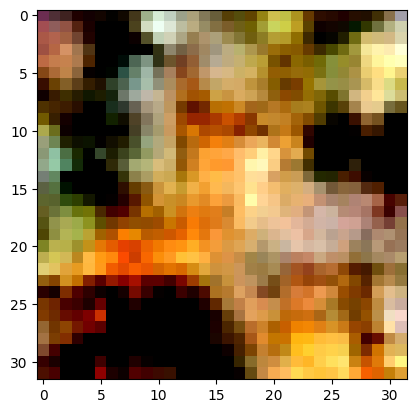

In [18]:
random_index = 0

fig = plt.figure()
ims = []
for i in range(TIME_STEPS):
    im = plt.imshow(np.array(imgs[i])[random_index], animated=True)
    ims.append([im])
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=5, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')
plt.show()

## Your turn! 🚀

Assignment - [Denoising difussion model](../assignments/deep-learning/difussion-model/denoising-difussion-model.ipynb)

## Acknowledgments

Thanks to [Kwangnam Yu](https://github.com/phykn) for creating the open-source project [diffusion_models_tutorial](https://github.com/phykn/diffusion_models_tutorial) and [kaggle](https://www.kaggle.com/) for creating the open-source courses [Denoising Diffusion Models with TensorFlow](https://www.kaggle.com/code/folefac/denoising-diffusion-models-with-tensorflow#3.-The-Celeb-A-Dataset-%F0%9F%92%BE)[Exploring Diffusion Models with JAX](https://www.kaggle.com/code/darshan1504/exploring-diffusion-models-with-jax)[Denoising Diffusion Probabilistic Model with TF](https://www.kaggle.com/code/junhyeok99/denoising-diffusion-probabilistic-model-with-tf#Mathematics-&-Workflow). They inspire the majority of the content in this chapter.